In [22]:
%load_ext autoreload
%autoreload 2

import music21 as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from data_helper import *
from music_helper import *

sns.set(font='Yu Gothic')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Bachセット

In [23]:
# Bach set
playerIds = [1, 2, 5, 8]
playerNames = ["YI", "ES", "HI", "NH"]
pieceRange = range(10)
# Mozart set
#playerIds = [1, 3, 4, 5, 6, 7] 
#playerNames = ["ES", "HI", "HK", "YI", "YS", "EF"]
#pieceRange = range(10, 20)
# Chopin set
#playerIds = [1, 3, 4, 5, 6] 
#playerNames = ["HI", "EF", "Yol", "EN", "ES"]
#pieceRange = range(20, 30)

pathes = []
pathes += ['./tmp/Result_FHMM' + str(order) + '/{dataId:03d}-1_fingering.txt' for order in [1,2,3]]
pathes += ['./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-' + str(playerId) + '_fingering.txt' for playerId in playerIds]

players = []
players += ['FHMM' + str(order) for order in [1,2,3]]
players += ['PIG_' + name for name in playerNames]

pieceTables = {}
for playerId, name in enumerate(players):
    pieceTables[name] = [read_PIG(pathes[playerId].format(dataId = pi + 1)) for pi in pieceRange]

In [24]:
pigList = pd.read_csv('./tmp/PianoFingeringDataset/List.csv')
pieces = pigList[pieceRange.start:pieceRange.stop]
pieces

,Id,Composer,Piece,#Bars,#Notes,#Fingering,Fingering 1,2,3,4,5,6,7,8
0,1,Bach,Two-part invention in C major,22,469,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
1,2,Bach,Two-part invention in F major,34,596,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
2,3,Bach,"Well-Tempered Clavier, Book I, Prelude No. 23 ...",19,417,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
3,4,Bach,"Well-Tempered Clavier, Book II, Fugue No. 2 in...",14,282,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
4,5,Bach,"Well-Tempered Clavier, Book II, Fugue No. 19 i...",14,313,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
5,6,Bach,Partita No. 6 Corrente,38,348,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
6,7,Bach,French Suite No. 1 Allemande,12,281,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
7,8,Bach,French Suite No. 5 Sarabande,16,171,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
8,9,Bach,English Suite No. 3 Prelude,33,393,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
9,10,Bach,"Goldberg Variations, Variation 13",16,387,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH


## 運指要素

In [35]:
columns = ["寄せ", "拡げ", "潜り", "超え", "静止"]
total = np.zeros(shape = (len(players), len(columns)))
for playerId, name in enumerate(players):
    tables = pieceTables[name]
    for ch in [0, 1]:
        actions = np.zeros(len(columns))
        for table in tables:
            notes = table[table.ch == ch]
            rest = False
            for pi in range(1, len(notes)):
                n = notes.iloc[pi]
                n_ = notes.iloc[pi - 1]
                td_ = n.t0 - n_.t1
                if td_ >= 1 / 32: # 休符を挟まない
                    rest = True
                    continue
                if not rest:
                    move = getMoveTypeByPIGNote(n, n_, False)
                    actions[move] += 1
                rest = False
        total[playerId] += actions

In [36]:
length = sum(map(lambda r: len(r), pieceTables[players[0]]))
dfa = pd.DataFrame(total, columns=columns, index=players)
dfa = dfa.drop('静止', axis = 1)
dfa['合計'] = dfa[columns[0:4]].sum(axis = 1)
#dfa.applymap(lambda n: round(n * 100 / length, 2))
dfa.applymap(lambda n: round(n, 2))

,寄せ,拡げ,潜り,超え,合計
FHMM1,29.0,655.0,106.0,89.0,879.0
FHMM2,39.0,637.0,96.0,85.0,857.0
FHMM3,47.0,620.0,108.0,91.0,866.0
PIG_YI,195.0,580.0,122.0,92.0,989.0
PIG_ES,263.0,429.0,90.0,83.0,865.0
PIG_HI,140.0,558.0,109.0,93.0,900.0
PIG_NH,203.0,548.0,101.0,102.0,954.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


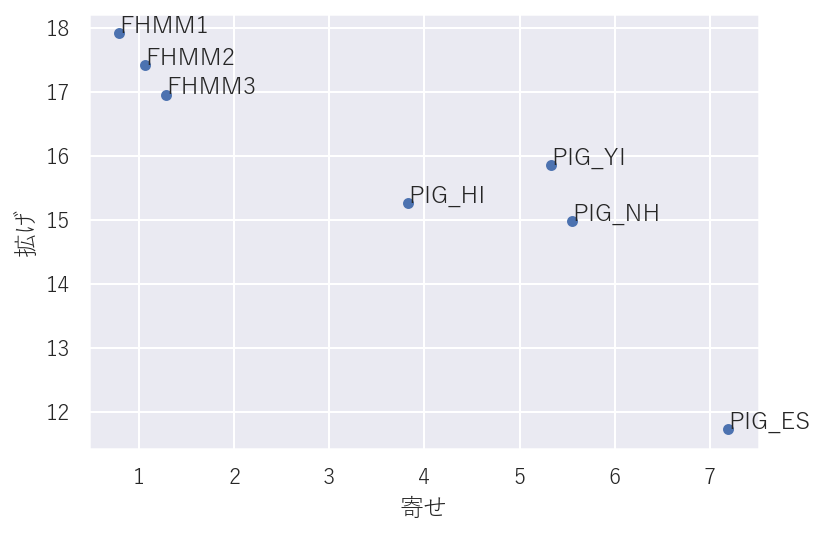

In [27]:
ax = dfa.plot.scatter(x = columns[0], y = columns[1])
for label, x, y in zip(dfa.index, dfa[columns[0]], dfa[columns[1]]):
    ax.annotate(label, (x, y))

In [61]:
x_ = dfa["寄せ"]
y_ = dfa["拡げ"]
xm = x_.mean()
xs = y_.std()
ym = x_.mean()
ys = y_.std()
x_.map(lambda x: pow(x - xm, 2)).mean()

2.5018750000000005

### 手の移動

In [39]:
costs = np.zeros(shape = (len(pieces), len(players)))
ch = 0
for ni, name in enumerate(players):
    tables = pieceTables[name]
    for wi, table in enumerate(tables):
        notes = table[table.ch == 0]
        rest = False
        sign = np.sign(ch + 0.5)
        hp = (notes.iloc[0].pos + (3 * sign) - notes.iloc[0].fingers[0])
        for pi in range(1, len(notes)):
            n = notes.iloc[pi]
            n_ = notes.iloc[pi - 1]
            td_ = n.t0 - n_.t1
            if td_ >= 1 / 32: # 休符を挟まない
                rest = True
                continue
            if not rest:
                move = getMoveTypeByPIGNote(n, n_, True)
                new_hp = ((n.pos + (3 * sign) - n.fingers[0]) + (n_.pos + (3 * sign) - n_.fingers[-1])) / 2
                d = new_hp - hp
                costs[wi, ni] += 1 if move != 4 else 0
                hp = new_hp
            rest = False

<AxesSubplot:ylabel='Piece'>

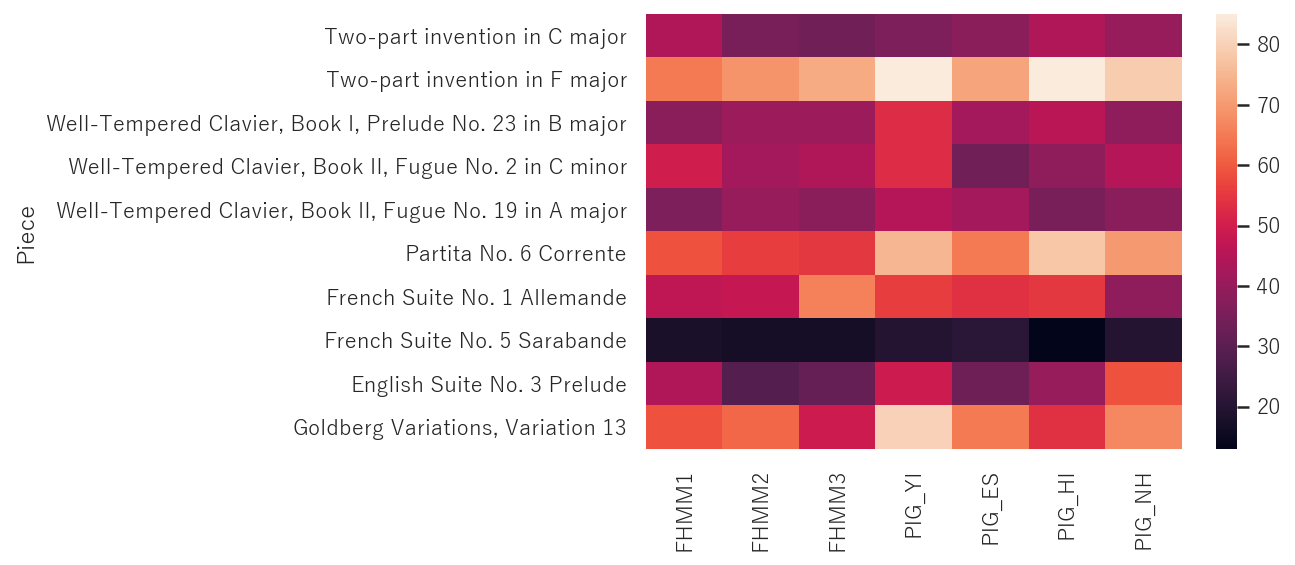

In [43]:
dfa = pd.DataFrame(costs, columns=players, index=pieces.iloc[:, 2])
sns.heatmap(dfa)